# **CNN From Scratch**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2 

In [2]:
data = pd.read_csv('/kaggle/input/fashionmnist/fashion-mnist_train.csv')
data

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,1,0,0,0,0,0,0,0,0,0,...,73,0,0,0,0,0,0,0,0,0
59997,8,0,0,0,0,0,0,0,0,0,...,160,162,163,135,94,0,0,0,0,0
59998,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
data = np.array(data)
m, n = np.shape(data)
np.random.shuffle(data)
print(f"m = {m}, n = {n}")

m = 60000, n = 785


In [4]:
index = m * 0.20
index

12000.0

In [5]:
data_train = data[12000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255.
_, m_train = X_train.shape

In [6]:
data_test = data[0:12000].T
Y_test = data_test[0]
X_test = data_test[1:n]
X_test = X_test / 255.

In [7]:
def one_hot_encode(labels, num_classes=10):
    num_labels = len(labels)
    one_hot = np.zeros((num_labels, num_classes))
    one_hot[np.arange(num_labels), labels.astype(int)] = 1
    return one_hot

X_train shape: (48000, 28, 28, 1)
Y_train shape: (48000, 10)
X_test shape: (12000, 28, 28, 1)
Y_test shape: (12000, 10)

Original label: 2
One-hot encoded [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
Sample image shape: (28, 28, 1)


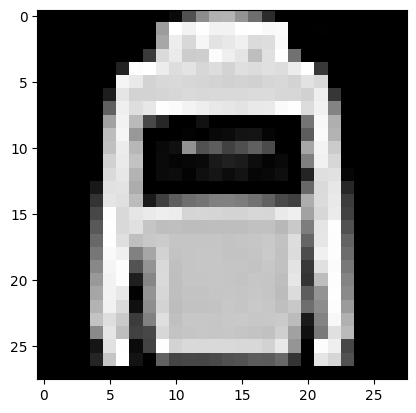

In [8]:
X_train = X_train.T.reshape(-1, 28, 28, 1)
X_test = X_test.T.reshape(-1, 28, 28, 1)
Y_train = one_hot_encode(Y_train)
Y_test = one_hot_encode(Y_test)

print("X_train shape:", X_train.shape) #(48000, 28, 28, 1)
print("Y_train shape:", Y_train.shape) #(48000, 10)
print("X_test shape:", X_test.shape) #(12000, 28, 28, 1)
print("Y_test shape:", Y_test.shape) #(12000, 1)

print("\nOriginal label:", np.argmax(Y_train[0]))
print("One-hot encoded", Y_train[0])

print("Sample image shape:", X_train[0].shape)
plt.imshow(X_train[0].squeeze(), cmap='gray')
plt.show()

In [9]:
def connection(input_data, weights, biases):
    return np.dot(input_data, weights) + biases

def connection_back(gradient_output, input_data, weights):
    gradient_weights = np.dot(input_data.T, gradient_output)
    gradient_biases = np.sum(gradient_output, axis=0, keepdims = True)
    gradient_input = np.dot(gradient_output, weights.T)

    return gradient_weights, gradient_biases, gradient_input
    
def conv(image, kernel):
    kernel_h, kernel_w = kernel.shape
    img_h, img_w = image.shape
    output_h = img_h - kernel_h + 1
    output_w = img_w - kernel_w + 1

    output = np.zeros((output_h, output_w))
    for i in range(output_h):
        for j in range(output_w):
            output[i, j] = np.sum(image[i:i+kernel_h, j:j+kernel_w] * kernel)
    return output

def conv_back(gradient_output, input_data, kernel):
    kernel_h, kernel_w = kernel.shape
    gradient_kernel = np.zeros_like(kernel)
    gradient_input = np.zeros_like(input_data)

    for i in range(gradient_output.shape[0]):
        for j in range(gradient_output.shape[1]):
            gradient_kernel += input_data[i:i+kernel_h, j:j+kernel_w] * gradient_output[i, j]
            gradient_input[i:i+kernel_h, j:j+kernel_w] += kernel * gradient_output[i, j]
            
    return gradient_kernel, gradient_input 

def relu(Z):
    return np.maximum(0, Z)

def relu_back(gradient_output, input_data):
    gradient_input = gradient_output.copy()
    gradient_input[input_data <= 0] = 0
    return gradient_input
    
def max_pooling(image, pool_size=(2,2)):
    pool_h, pool_w = pool_size
    img_h, img_w = image.shape
    output_h = img_h // pool_h
    output_w = img_w // pool_w

    output = np.zeros((output_h, output_w))

    for i in range(output_h):
        for j in range(output_w):
            output[i, j] = np.max(image[i * pool_h: (i+1)*pool_h, j * pool_w: (j+1)*pool_w])
    return output

def max_pooling_back(gradient_output, input_data, pool_size=(2,2)):
    pool_h, pool_w = pool_size
    img_h, img_w = input_data.shape
    output_h = img_h // pool_h
    output_w = img_w // pool_w

    gradient_input = np.zeros_like(input_data)

    for i in range(output_h):
        for j in range(output_w):
            pool_region = input_data[i * pool_h:(i+1)*pool_h, j*pool_w:(j+1)*pool_w]
            max_index = np.unravel_index(np.argmax(pool_region), pool_region.shape)
            gradient_input[i*pool_h + max_index[0], j*pool_w + max_index[1]] = gradient_output[i, j]
    return gradient_input

def softmax(x):
    exp_x = np.exp(x - np.max(x))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def softmax_cross_entropy(pred, target):
    return pred - target

In [10]:
class CNN:
    def __init__(self):
        self.conv_kernel = np.random.uniform(-0.1, 0.1, (3,3))
        self.fc_weights = np.random.uniform(-0.1, 0.1, (13 * 13 * 1, 10))
        self.fc_biases = np.zeros((1, 10))
        self.cache = {}

    def forward(self, input_img):
        conv_output = conv(input_img.squeeze(), self.conv_kernel)
        self.cache['conv_output'] = conv_output
        
        relu_output = relu(conv_output)
        self.cache['relu_output'] = relu_output

        pooled_output = max_pooling(relu_output)
        self.cache['pooled_output'] = pooled_output

        flattened = pooled_output.flatten()
        self.cache['flattened'] = flattened

        fc_output = connection(flattened, self.fc_weights, self.fc_biases)
        self.cache['fc_output'] = fc_output

        output_probs = softmax(fc_output.reshape(1, -1))
        self.cache['output_probs'] = output_probs

        return output_probs

    def backward(self, input_img, target):
        conv_output = self.cache['conv_output']
        relu_output = self.cache['relu_output']
        pooled_output = self.cache['pooled_output']
        flattened = self.cache['flattened']
        fc_output = self.cache['fc_output']
        output_probs = self.cache['output_probs']

        grad_softmax = softmax_cross_entropy(output_probs, target)

        grad_fc_weights, grad_fc_biases, grad_flattened = connection_back(
            grad_softmax, flattened.reshape(1, -1), self.fc_weights
        )

        grad_pooled = grad_flattened.reshape(pooled_output.shape)

        grad_relu = max_pooling_back(grad_pooled, relu_output)

        grad_conv = relu_back(grad_relu, conv_output)

        grad_kernel, grad_input = conv_back(grad_conv, input_img.squeeze(), self.conv_kernel)

        return grad_kernel, grad_fc_weights, grad_fc_biases

In [11]:
def cross_entropy_loss(predictions, label):
    m = label.shape[1]
    loss = -np.sum(label*np.log(predictions + 1e-8)) / m
    return loss

In [12]:
def train_CNN(CNN, X_train, Y_train, epochs=10, learning_rate=0.01):
    for epoch in range(epochs):
        total_loss = 0
        for i in range(len(X_train)):
            input_img = X_train[i]
            target = Y_train[i]

            predictions = CNN.forward(input_img)

            loss = cross_entropy_loss(predictions, target.reshape(1, -1))
            total_loss += loss

            grad_kernel, grad_fc_weights, grad_fc_biases = CNN.backward(input_img, target)

            CNN.conv_kernel -= learning_rate * grad_kernel
            CNN.fc_weights -= learning_rate * grad_fc_weights
            CNN.fc_biases -= learning_rate * grad_fc_biases
            

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(X_train)}")

In [13]:
def evaluate_CNN(CNN, X_test, Y_test):
    correct = 0
    for i in range(len(X_test)):
        input_img = X_test[i]
        target = Y_test[i]

        predictions = CNN.forward(input_img)
        predicted_class = np.argmax(predictions)
        true_class = np.argmax(target)

        if predicted_class == true_class:
            correct += 1
    accuracy = correct / len(X_test)
    print(f"Test Accuracy: {accuracy * 100:.3f}%")
    

In [14]:
CNN = CNN()
train_CNN(CNN, X_train, Y_train, epochs=5, learning_rate=0.01)
evaluate_CNN(CNN, X_test, Y_test)

Epoch 5, Loss: 0.04733908313979075
Test Accuracy: 81.208%


# **CNN Using Torch**

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [16]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])
train_dataset = datasets.FashionMNIST(root='./data',train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

100%|██████████| 26.4M/26.4M [00:01<00:00, 18.8MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 302kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 5.69MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 10.7MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [17]:
class TorchCNN(nn.Module):
    def __init__(self):
        super(TorchCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 14 * 14, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 16 * 14 * 14)
        x = self.fc1(x)

        return F.softmax(x, dim=1)

model = TorchCNN()

criterion = nn.CrossEntropyLoss()

learning_rate = 0.01
num_epochs = 5

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        for param in model.parameters():
            if param.grad is not None:
                param.grad.zero_()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()

        with torch.no_grad():
            for param in model.parameters():
                param -= learning_rate * param.grad

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")
print("Training complete.")

Epoch [1/5], Loss: 1.8764
Epoch [2/5], Loss: 1.7146
Epoch [3/5], Loss: 1.6922
Epoch [4/5], Loss: 1.6815
Epoch [5/5], Loss: 1.6742
Training complete.
